# Titanic 승객 생존 확률 계산 모델
승객의 생존 여부(survived)를 티켓 클래스(Pclass), 성별, 나이, 동승한 가족의 수(SibSp:형제 및 배우자, Parch:부모 및 자식), 탑승료(fare), 객실 번호(cabin) 등으로부터 유추하는 것이 목표이다.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 매 그림마다 font size 지정할 필요 없이 scale 지정

import missingno as msno

%matplotlib inline

## 1. Dataset 확인

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#df_train = pd.read_csv(os.path.join(dirname, filenames[0])
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.describe() # 통계치를 확인하면, age의 count가 전체 승객 count보다 작다. 즉 null이 존재하는 것으로 보인다.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.1 Null data check

In [6]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of Nan value: {:.2f}%'.format(col,100*(df_train[col].isnull().sum()/df_train[col].shape[0]))
    print(msg)

"""
1. {:>10}\t 은 똑같이 10칸 뒤에 끝이 오도록 \tab을 준다는 뜻. :<은 좌측 정렬, :>은 우측 정렬. (자세한 건 https://www.w3schools.com/python/ref_string_format.asp 참조)

2.
df_train[col].isnull().sum()은 각 column마다 isnull의 수를 합한다는 뜻이고
df_train[col].shape[0]은 각 column의 row 수를 의미한다.
좀 더 구체적으로 설명하면 .shape는 numpy array의 dimension을 반환하는데 X.shape가 (n,m)이면 X.shape[0]은 n이 된다.

3.
msg = 'string {} string {}'.format(col,value)은 문장 안의 {}마다 해당하는 값을 출력한다.
"""

column: PassengerId	 Percent of Nan value: 0.00%
column:   Survived	 Percent of Nan value: 0.00%
column:     Pclass	 Percent of Nan value: 0.00%
column:       Name	 Percent of Nan value: 0.00%
column:        Sex	 Percent of Nan value: 0.00%
column:        Age	 Percent of Nan value: 19.87%
column:      SibSp	 Percent of Nan value: 0.00%
column:      Parch	 Percent of Nan value: 0.00%
column:     Ticket	 Percent of Nan value: 0.00%
column:       Fare	 Percent of Nan value: 0.00%
column:      Cabin	 Percent of Nan value: 77.10%
column:   Embarked	 Percent of Nan value: 0.22%


"\n1. {:>10}\t 은 똑같이 10칸 뒤에 끝이 오도록 \tab을 준다는 뜻. :<은 좌측 정렬, :>은 우측 정렬. (자세한 건 https://www.w3schools.com/python/ref_string_format.asp 참조)\n\n2.\ndf_train[col].isnull().sum()은 각 column마다 isnull의 수를 합한다는 뜻이고\ndf_train[col].shape[0]은 각 column의 row 수를 의미한다.\n좀 더 구체적으로 설명하면 .shape는 numpy array의 dimension을 반환하는데 X.shape가 (n,m)이면 X.shape[0]은 n이 된다.\n\n3.\nmsg = 'string {} string {}'.format(col,value)은 문장 안의 {}마다 해당하는 값을 출력한다.\n"

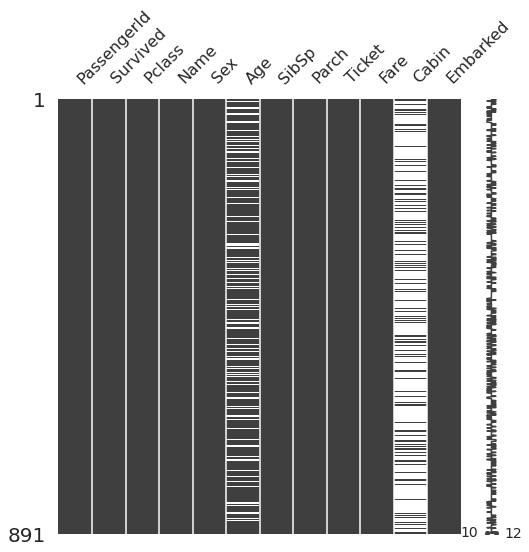

In [7]:
msno.matrix(df=df_train.iloc[:,:], figsize=(8,8))
# missingno 라이브러리를 사용하면 더 직관적으로 null을 확인할 수 있다.
# 근데 맨 오른쪽은 뭐지?

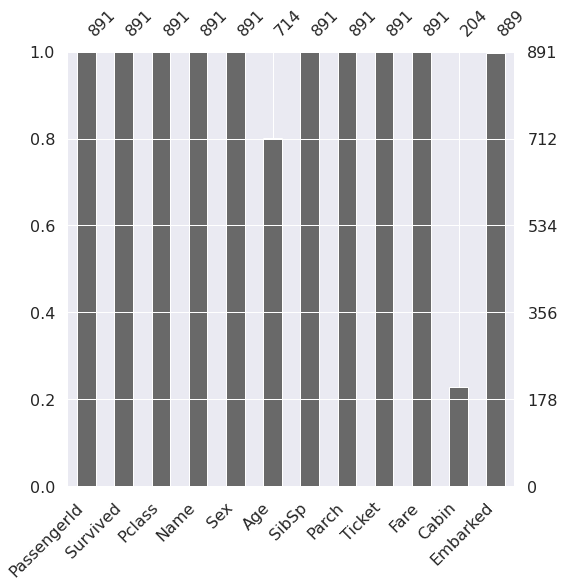

In [8]:
msno.bar(df=df_train.iloc[:,:], figsize=(8,8))
# 이건 null의 개수를 보여준다.
# df.iloc[]은 dataframe에서 원하는 구간을 slicing할 때 사용한다.

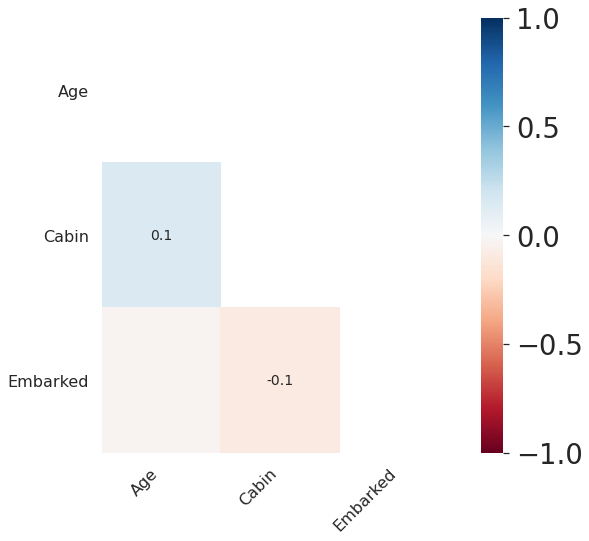

In [9]:
msno.heatmap(df=df_train.iloc[:,:], figsize=(8,8))
# 이건 null 간의 상관을 보여준다 (예: 'Age'가 없는 데이터에는 'Cabin'도 없다.)

## 1.2 Target label 확인
target label (survived)의 distribution을 확인해야 한다. 특히 지금과 같은 binary classification 문제의 경우, 1과 0의 분포에 따라 모델 평가 방법이 달라질 수 있기 때문이다.

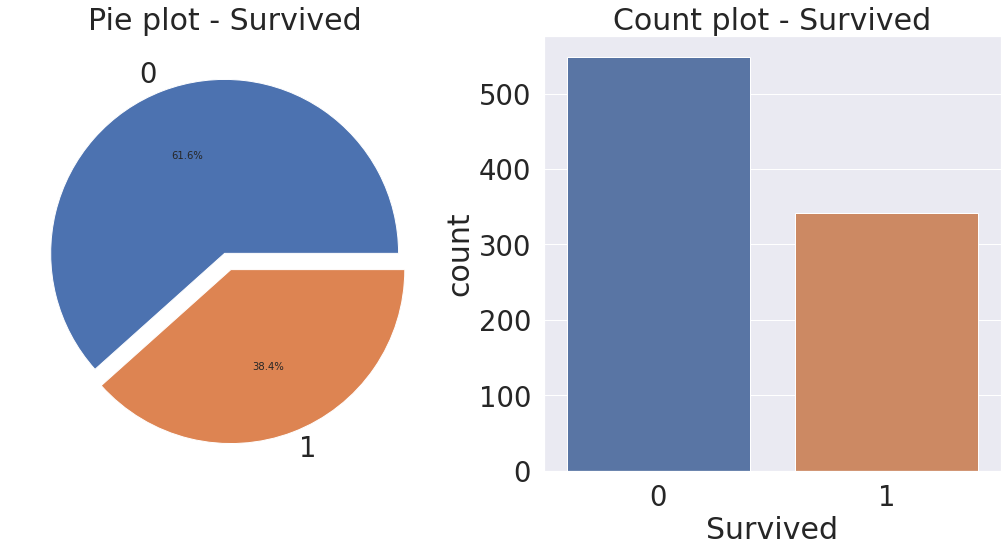

In [10]:
f, ax = plt.subplots(1,2,figsize=(18,8))

df_train['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=df_train,ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

In [11]:
df_train['Survived'].value_counts(normalize=True) # normalize: count 대신 frequency 
df_train['Age'].value_counts(bins=5)  # bins: 범주를 나누어 count
#df_train['Survived'].value_counts().plot()

(16.336, 32.252]    346
(32.252, 48.168]    188
(0.339, 16.336]     100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

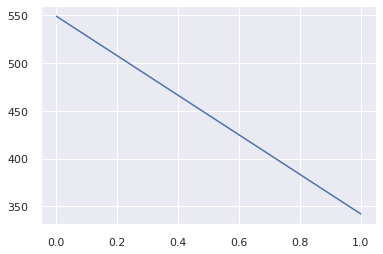

In [12]:
sns.set() # matplotlib나 dataframe plot에서도 sns.set을 통해 seaborn을 적용할 수 있다.
df_train['Survived'].value_counts().plot()
plt.show()

binary classification에서 0과 1의 분포가 지나치게 치우친 경우(예: 1이 99개, 0이 1개) 모델이 전부 1이라고 예측해도 모델 정확도가 과하게 높은 이슈가 발생한다. 그러나 이 target label은 분포가 균일(balanced)하므로 위의 이슈를 고려하지 않아도 된다.

## 2. Exploratory data analysis

### 2.1 Pclass (티켓 클래스)
Pclass는 ordinal data (서순형 자료, 데이터가 속하는 category에 순서가 있는 경우. 예: 설문조사 답변-매우 그렇다(5), ... 매우 그렇지 않다(1))이다.  

In [13]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).count()
# df.groupby(['label']) 이용해 특정 label에 관한 통계치(mean, count, ...)를 구할 수 있다.
# df.groupby(as_index=True)는 default이며 분류 시 특정 label을 새로운 index로 만든다.

,Survived
Pclass,
1,216
2,184
3,491


In [14]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


groupby(['Pclass']).count()를 통해 각 class당 인원수를 구하였고 .sum()을 통해 생존자(1)의 수를 구하였다. 위 과정을 pd.crosstab을 사용하면 더 수월하게 수행할 수 있다.

In [15]:
pd.crosstab(df_train['Pclass'],df_train['Survived'],margins=True).style.background_gradient(cmap='RdPu')
# crosstab은 별도의 array나 aggreagation function (집계함수?)이 전달되지 않은 한 '빈도수' 테이블을 보여준다.
# margins=True는 subtotal (All)을 켜고 끈다.

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


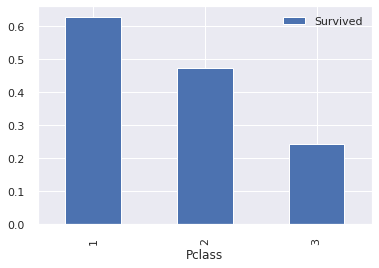

In [18]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()
# class가 높을수록 mean (생존확률)이 높다.

 seaborn의 countplot을 사용하면 특정 label당 개수를 확인할 수 있다.

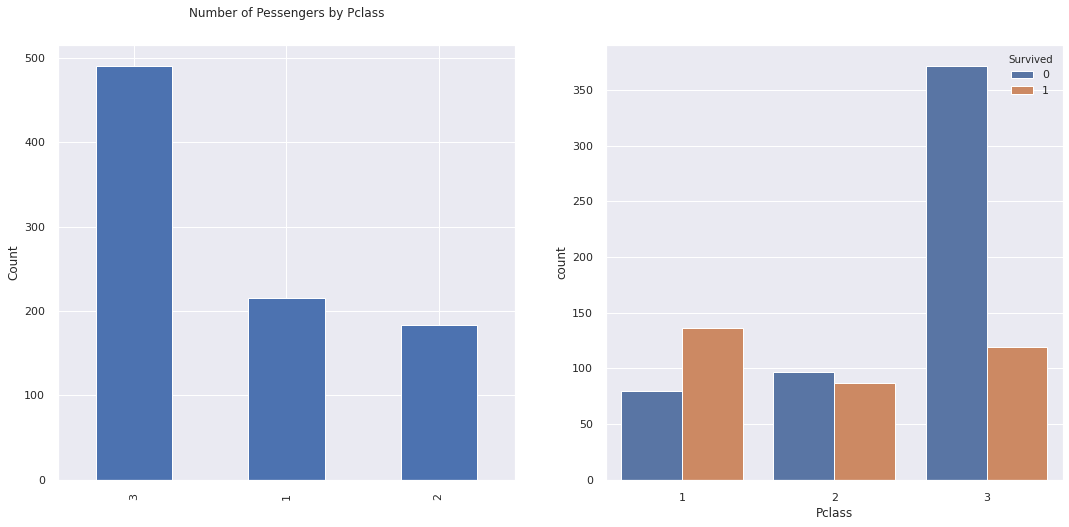

In [34]:
title_position = 1.05
f, ax = plt.subplots(1,2,figsize=(18,8))

# 기존 방식
df_train['Pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number of Pessengers by Pclass',y=title_position) # set_title(y=숫자)는 title의 위치를 조정한다. (1은 그림 바로 위)
ax[0].set_ylabel('Count')

# seaborn countplot
sns.countplot('Pclass',hue='Survived', data=df_train,ax=ax[1]) # x label당 hue label을 센다.
ax[1].set_title('Pclass: Survived vs. Dead', y=title_position)
